In [1]:
from numqt import Mesh, canonic_ops, ho_state, sparse, Hamiltonian
import numpy as np
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# parameters and mesh setup
#-----------------------------------------------------------
a = 1 # "characteristic bounds" of ground state
xbounds = (-a, a)
L = np.abs(xbounds[1] - xbounds[0]) # characteristic parabolic length
dx = 0.001  
nx = int(np.abs(xbounds[1] - xbounds[0]) / dx)
mesh = Mesh(dims=1, xbounds=xbounds, nx=nx)

hbar = 1
m = 1
q = 1

N_states = 5
Nt = 5000 # number of partitions of the computation of U(T, 0)
w = hbar/(m*L**2)
# ===========================================================
# Setup 
# ===========================================================
omega = 0.95 * 3 * hbar * np.pi**2 / (2 * m * L**2)
T = 2 * np.pi / omega
E0_vals = np.linspace(0, - 10 * hbar * omega / (q * a), 300)
E0_normalized = - E0_vals * q * a / (hbar * omega)

time_dep_args = {
    "amplitudes": E0_vals,
    "frequencies": omega,
    "periods": T
}


psi_fn   = lambda n, mesh: ho_state(n=n, mesh=mesh, omega=w, mass=m, hbar=hbar)
basis    = (psi_fn, N_states)

# Get operators
operators = canonic_ops(mesh, basis=basis, ops_to_compute=["p2","p", "x2", "x"], hbar=hbar, threshold=1e-15)
ops = operators.get_ops()
px = ops["p"]
px2 = ops["p2"]
x = ops["x"]
x2= ops["x2"]
identity = sparse.eye(x.shape[0])

# Static Hamiltonian
H0 = (px2 / (2*m) + 0.5 * m * x2 * w**2)

In [2]:
# ===========================================================
# EXAMPLE 1: Dipole approx
# ===========================================================
print("=== EXAMPLE 1: Dipole approx ===")


# Time-dependent Hamiltonian
def H_dip (E0, w, t): 
    return (- q * E0 * np.cos(w * t) * x)

# Create Hamiltonian with array parameter
H_array_E0 = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_dip, 
                         time_dep_args=time_dep_args,  # E0_vals is an array!
                         mesh=mesh,
                         basis=basis,
                         verbose=True)

quasi_energies_dip = H_array_E0.solve_quasi_energies(Nt=Nt)

=== EXAMPLE 1: Dipole approx ===
Starting quasi-energy calculation for 300 parameter set(s)...
Output shape will be: (300, 1, 5)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

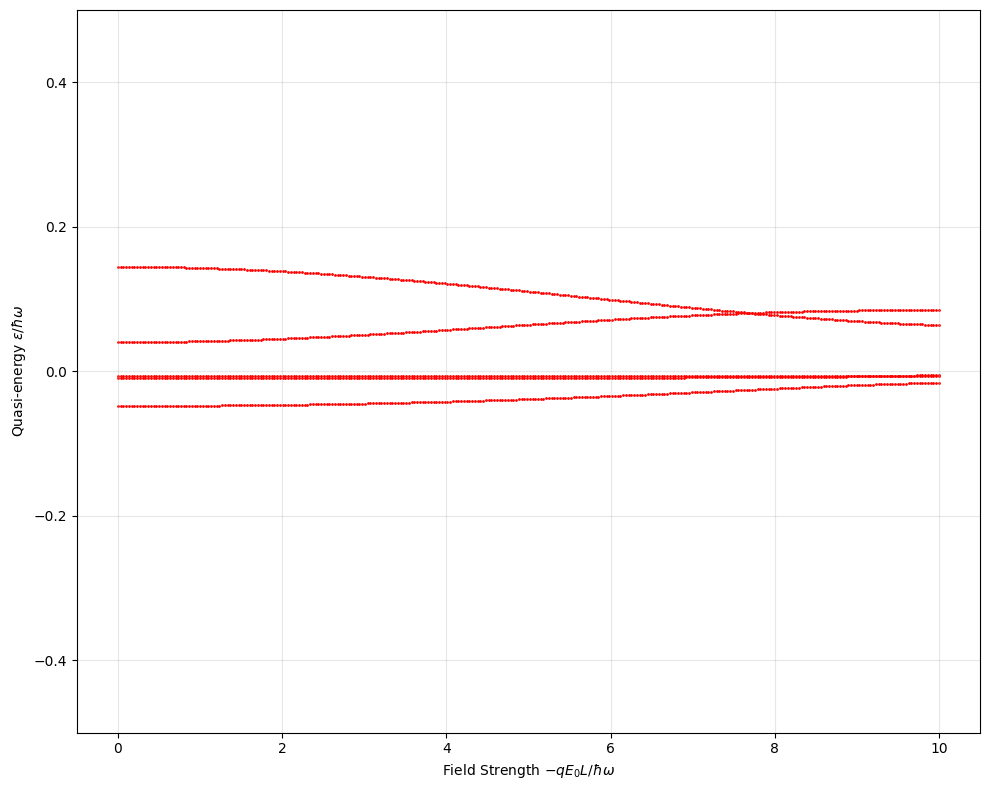

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(100,N_states)):  # Show first 9 levels
    ax.scatter(E0_normalized, quasi_energies_dip[:, 0, n], c = "r", s=1,  alpha=1)

ax.set_xlabel('Field Strength $-q E_0 L / \\hbar\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [4]:
# ===========================================================
# EXAMPLE 2: Two array parameters (E0_vals and omega_vals)
# ===========================================================
print("\n=== EXAMPLE 2: Arrays of E0 with minimal coupling substituion ===")

def H_mcs(E0, omega, t):
    """Time-dependent Hamiltonian that works with scalar parameters"""
    A_t = E0/omega * np.sin(omega * t)
    return (- q *  A_t * px / m + q**2 * A_t**2 / (2*m) * identity)

# Create Hamiltonian with two array parameters
H_array_mc = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_mcs, 
                         time_dep_args=time_dep_args,
                         mesh=mesh,
                         basis=basis,
                         verbose=False)

quasi_energies_mcs = H_array_mc.solve_quasi_energies(Nt=Nt)


=== EXAMPLE 2: Arrays of E0 with minimal coupling substituion ===


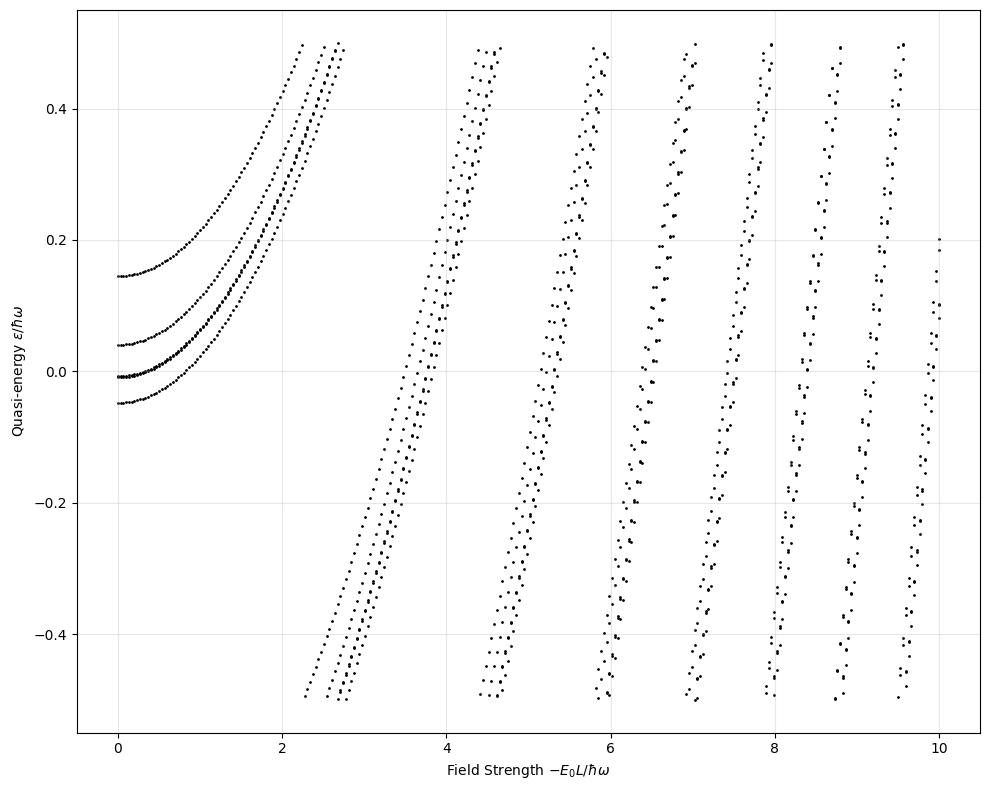

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(20,N_states)):  # Show first 9 levels
    ax.scatter(E0_normalized, quasi_energies_mcs[:, 0, n], c = "k", s=1,  alpha=1)

ax.set_xlabel('Field Strength $-E_0 L / \\hbar\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [6]:
# ===========================================================
# EXAMPLE 3: Mixed scalar and array parameters
# ===========================================================
print("\n=== EXAMPLE 3: Results obtained via velocity gauge ===")

def H_vel(E0, omega, t):
    """Time-dependent Hamiltonian that works with scalar parameters"""
    A_t = E0/omega * np.sin(omega * t)
    
    U_vel = sparse.linalg.expm(-1j * q / hbar * A_t * x.tocsc())
    Uc_vel = np.conjugate(U_vel.T)
    return (U_vel @ H0 @ Uc_vel)


H_array_vel = Hamiltonian(H_time_indep= 0*H_vel(1,1,1), 
                             H_time_dep=H_vel, 
                             time_dep_args=time_dep_args,
                             mesh=mesh,
                             basis=basis,
                             verbose=True)

quasi_energies_vel = H_array_vel.solve_quasi_energies(Nt=Nt)


=== EXAMPLE 3: Results obtained via velocity gauge ===
Starting quasi-energy calculation for 300 parameter set(s)...
Output shape will be: (300, 1, 5)
Parallel computation using all cores.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

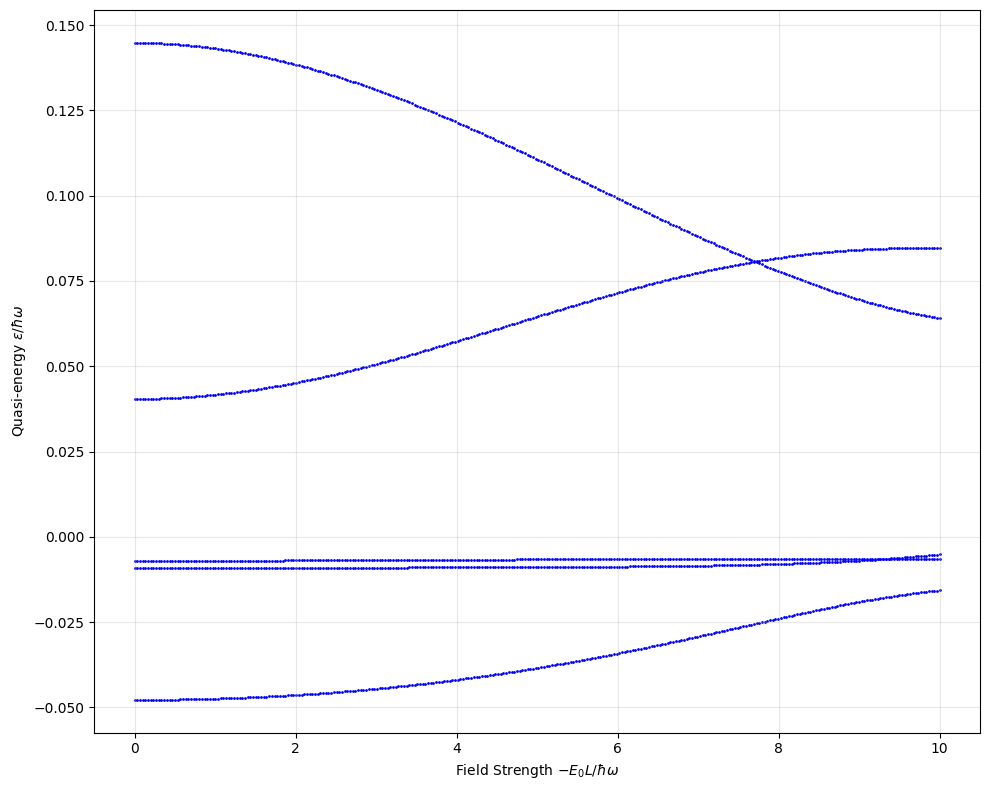

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(20,N_states)):  # Show first 9 levels
    ax.scatter(E0_normalized, quasi_energies_vel[:,0, n], c = "b", s=1,  alpha=1)

ax.set_xlabel('Field Strength $-E_0 L / \\hbar\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

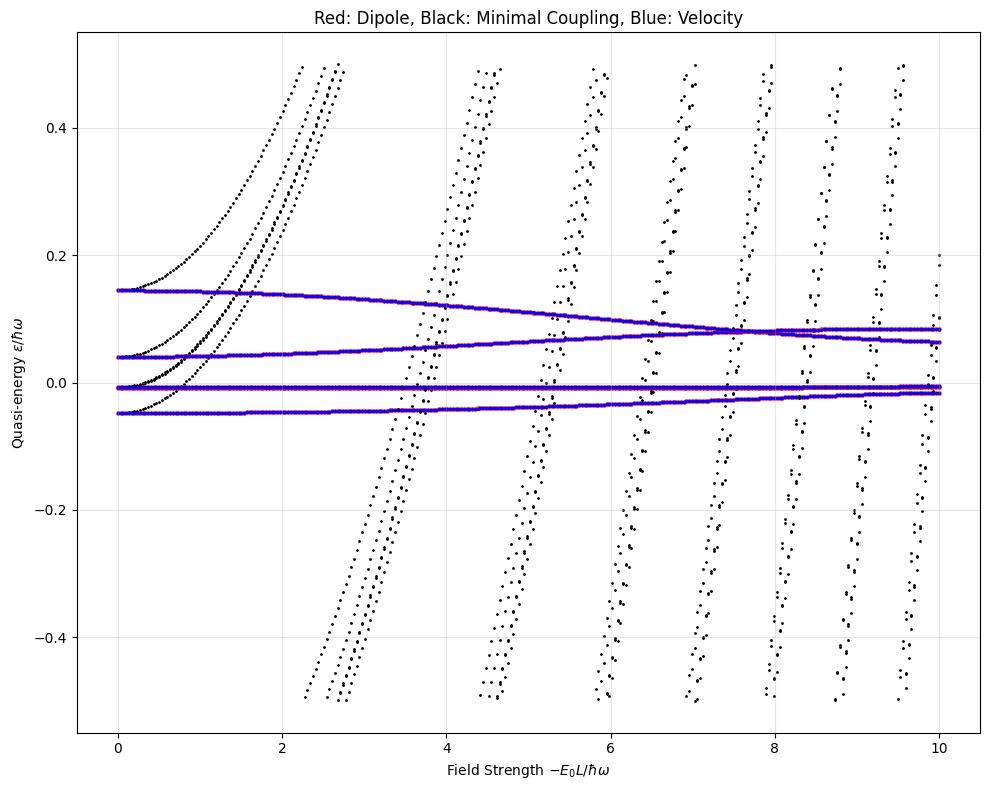

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(20,N_states)):  # Show first 9 levels
    ax.scatter(E0_normalized, quasi_energies_dip[:, 0, n], c = "r", s=6,  alpha=0.7, marker="o")
    ax.scatter(E0_normalized, quasi_energies_mcs[:, 0, n], c = "k", s=1,  alpha=1)
    ax.scatter(E0_normalized, quasi_energies_vel[:, 0, n], c = "b", s=2,  alpha=1)

ax.set_xlabel('Field Strength $-E_0 L / \\hbar\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.set_title('Red: Dipole, Black: Minimal Coupling, Blue: Velocity')
ax.grid(True, alpha=0.3)
#ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()